In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        # Check if the file is an image file
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Add other image extensions if needed
            img = image.load_img(os.path.join(path, file), target_size=(224, 224, 3))
            images.append(image.img_to_array(img))
            labels.append((label))

    # Print a message if no images were found
    if not images:
        print(f"No images found in the directory: {path}")

    return images, labels

import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
import math
%matplotlib inline

# ... (rest of the code remains the same)

def show_images(images, grid_size=(4, 4)):  # Default grid size is 4x4
    """
    Displays images in a grid format.

    Args:
        images: A list of images (NumPy arrays).
        grid_size: A tuple (rows, cols) specifying the grid dimensions.
    """
    num_images = len(images)

    # Handle the case where there are no images
    if num_images == 0:
        print("No images to display.")
        return

    # Calculate grid dimensions based on the number of images and grid size
    num_rows = grid_size[0]
    num_cols = grid_size[1]
    num_images_to_display = min(num_images, num_rows * num_cols)

    # Create subplots with the calculated grid dimensions
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Display images on subplots
    for i in range(num_images_to_display):
        axes[i].imshow(images[i] / 255)

    # Hide any extra subplots if there are fewer images than grid cells
    for i in range(num_images_to_display, num_rows * num_cols):
        axes[i].axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

x_train = []
y_train = []
x_test = []
y_test = []

In [4]:
images, labels = load_images_from_path('/content/drive/MyDrive/data/train/arctic_fox', 0)
x_train += images
y_train += labels

In [5]:
images, labels = load_images_from_path('/content/drive/MyDrive/data/train/polar_bear', 1)

x_train += images
y_train += labels

In [6]:
images, labels = load_images_from_path('/content/drive/MyDrive/data/train/walrus', 2)


x_train += images
y_train += labels

In [7]:
images, labels = load_images_from_path('/content/drive/MyDrive/data/test/arctic_fox', 0)

x_test += images
y_test += labels

In [8]:
images, labels = load_images_from_path('/content/drive/MyDrive/data/test/polar_bear', 1)

x_test += images
y_test += labels

In [9]:
images, labels = load_images_from_path('/content/drive/MyDrive/data/test/walrus', 2)

x_test += images
y_test += labels

In [10]:
from tensorflow.keras.utils import to_categorical

x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [11]:
# Stage 1: Define a function to create a CNN model with specific hyperparameters
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # Import Dropout
from keras.models import Sequential
from keras.optimizers import Adam

def create_tuned_cnn(kernel_size, num_filters, learning_rate, dropout_rate, dense_units, activation):
    tuned_model = Sequential([
        Conv2D(num_filters, kernel_size, activation=activation, input_shape=x_train.shape[1:]),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(dense_units, activation=activation),
        Dropout(dropout_rate),
        Dense(y_train_encoded.shape[1], activation='softmax')  # Adjust output layer for number of classes
    ])
    optimizer = Adam(learning_rate=learning_rate)
    tuned_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return tuned_model

In [12]:
# Stage 2: Define ranges for hyperparameters
from random import randint, uniform, choice

num_trials = 5 # Number of random combinations to try

# Store results for each trial
results = []


In [13]:
# Stage 3: Train and evaluate models with random hyperparameters
for trial in range(num_trials):
    print(f"Trial {trial + 1}/{num_trials}")

    # Randomly select hyperparameters
    kernel_size = randint(2, 5)  # Random kernel size between 2 and 5
    num_filters = randint(16, 64)  # Random number of filters between 16 and 64
    learning_rate = round(uniform(0.0001, 0.01), 5)  # Random learning rate between 0.0001 and 0.01
    dropout_rate = round(uniform(0.2, 0.5), 2)  # Random dropout rate between 0.2 and 0.5
    dense_units = randint(64, 256)  # Random number of neurons in the dense layer
    activation = choice(['relu', 'tanh'])  # Random activation function

    print(f"Testing with kernel_size={kernel_size}, num_filters={num_filters}, learning_rate={learning_rate}, "
          f"dropout_rate={dropout_rate}, dense_units={dense_units}, activation={activation}")

    # Create and train the model
    tuned_model = create_tuned_cnn((kernel_size, kernel_size), num_filters, learning_rate, dropout_rate, dense_units, activation)
    history = tuned_model.fit(x_train, y_train_encoded, epochs=5, batch_size=randint(32, 128), validation_data=(x_test, y_test_encoded), verbose=0)

    # Evaluate the model
    y_pred = tuned_model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test_encoded, axis=1)

    # Compute classification metrics
    from sklearn.metrics import classification_report
    report = classification_report(y_true, y_pred_classes, output_dict=True)
    accuracy = report['accuracy']
    precision = np.mean([v['precision'] for k, v in report.items() if k.isdigit()])
    recall = np.mean([v['recall'] for k, v in report.items() if k.isdigit()])
    f1_score = np.mean([v['f1-score'] for k, v in report.items() if k.isdigit()])

    # Store trial results
    results.append({
        'kernel_size': kernel_size,
        'num_filters': num_filters,
        'learning_rate': learning_rate,
        'dropout_rate': dropout_rate,
        'dense_units': dense_units,
        'activation': activation,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    })
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")


Trial 1/5
Testing with kernel_size=5, num_filters=41, learning_rate=0.002, dropout_rate=0.22, dense_units=104, activation=relu


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step
Accuracy: 0.4833, Precision: 0.4533, Recall: 0.4833, F1-Score: 0.4275
Trial 2/5
Testing with kernel_size=3, num_filters=51, learning_rate=0.00569, dropout_rate=0.45, dense_units=138, activation=relu


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step
Accuracy: 0.4583, Precision: 0.4196, Recall: 0.4583, F1-Score: 0.4245
Trial 3/5
Testing with kernel_size=4, num_filters=45, learning_rate=0.0036, dropout_rate=0.28, dense_units=120, activation=relu


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 556ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy: 0.4083, Precision: 0.3989, Recall: 0.4083, F1-Score: 0.3304
Trial 4/5
Testing with kernel_size=3, num_filters=34, learning_rate=0.00115, dropout_rate=0.28, dense_units=103, activation=tanh
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src

Accuracy: 0.3417, Precision: 0.4454, Recall: 0.3417, F1-Score: 0.1840
Trial 5/5
Testing with kernel_size=5, num_filters=51, learning_rate=0.0089, dropout_rate=0.49, dense_units=73, activation=tanh
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 706ms/step
Accuracy: 0.3333, Precision: 0.1577, Recall: 0.3333, F1-Score: 0.1849


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Stage 4: Find and display the best hyperparameter combination
best_result = max(results, key=lambda x: x['accuracy'])
# Stage 4: Find and display the best hyperparameter combination
best_result = max(results, key=lambda x: x['accuracy'])
print("\nBest Hyperparameters:")
print(best_result)



Best Hyperparameters:
{'kernel_size': 5, 'num_filters': 41, 'learning_rate': 0.002, 'dropout_rate': 0.22, 'dense_units': 104, 'activation': 'relu', 'accuracy': 0.48333333333333334, 'precision': 0.45333333333333337, 'recall': 0.4833333333333334, 'f1_score': 0.4274797666102013}


In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
import numpy as np

# Define the number of folds for cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize lists to store metrics
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

print(f"\nPerforming {k_folds}-Fold Cross-Validation...")

# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(x_train)):
    print(f"\nFold {fold + 1}/{k_folds}")

    # Split data into training and validation sets
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    # Create model with best hyperparameters
    model = create_tuned_cnn(
        kernel_size=(best_result['kernel_size'], best_result['kernel_size']),
        num_filters=best_result['num_filters'],
        learning_rate=best_result['learning_rate'],
        dropout_rate=best_result['dropout_rate'],
        dense_units=best_result['dense_units'],
        activation=best_result['activation']
    )

    # Train the model on the fold
    history = model.fit(
        x_train_fold, y_train_fold,
        epochs=10,  # Adjust epochs as needed
        batch_size=64,
        validation_data=(x_val_fold, y_val_fold),
        verbose=1
    )

    # Evaluate on the validation fold
    y_val_pred = model.predict(x_val_fold)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true = np.argmax(y_val_fold, axis=1)

    # Compute metrics
    report = classification_report(y_val_true, y_val_pred_classes, output_dict=True)
    accuracy = report['accuracy']
    precision = np.mean([v['precision'] for k, v in report.items() if k.isdigit()])
    recall = np.mean([v['recall'] for k, v in report.items() if k.isdigit()])
    f1_score = np.mean([v['f1-score'] for k, v in report.items() if k.isdigit()])

    # Store metrics
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1_score)

    print(f"Fold {fold + 1} Metrics:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")

# Compute average metrics across folds
average_accuracy = np.mean(fold_accuracies)
average_precision = np.mean(fold_precisions)
average_recall = np.mean(fold_recalls)
average_f1_score = np.mean(fold_f1_scores)

print("\nCross-Validation Results:")
print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1-Score: {average_f1_score:.4f}")

# Retrain final model on the full training set
print("\nRetraining Final Model with Full Training Set...")
final_model = create_tuned_cnn(
    kernel_size=(best_result['kernel_size'], best_result['kernel_size']),
    num_filters=best_result['num_filters'],
    learning_rate=best_result['learning_rate'],
    dropout_rate=best_result['dropout_rate'],
    dense_units=best_result['dense_units'],
    activation=best_result['activation']
)

final_model.fit(
    x_train, y_train_encoded,
    epochs=10,
    batch_size=64,
    validation_data=(x_test, y_test_encoded),
    verbose=1
)

# Evaluate final model on test set
y_test_pred = final_model.predict(x_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(y_test_encoded, axis=1)

final_report = classification_report(y_test_true, y_test_pred_classes, output_dict=True)
test_accuracy = final_report['accuracy']

print("\nFinal Model Performance on Test Set:")
print(f"Test Accuracy: {test_accuracy:.4f}")



Performing 5-Fold Cross-Validation...

Fold 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.3258 - loss: 117.5993 - val_accuracy: 0.6000 - val_loss: 3.7115
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.4210 - loss: 8.3452 - val_accuracy: 0.3833 - val_loss: 2.5255
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.3686 - loss: 2.3934 - val_accuracy: 0.4667 - val_loss: 0.9601
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.4588 - loss: 1.1941 - val_accuracy: 0.6000 - val_loss: 0.9309
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.5771 - loss: 0.9548 - val_accuracy: 0.3833 - val_loss: 1.0682
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.6509 - loss: 1.0065 - val_accuracy: 0.4167 - val_loss: 1.0384
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.7675 - loss: 0.9313 - val_accuracy: 0.4333 - val_loss: 0.9717
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.7176 - loss: 0.7770 - val_accuracy: 0.3833 - val_loss: 0.9904
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - accuracy: 0.3801 - loss: 84.8582 - val_accuracy: 0.4833 - val_loss: 35.7081
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.4076 - loss: 22.1515 - val_accuracy: 0.3833 - val_loss: 1.1329
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.5376 - loss: 1.0090 - val_accuracy: 0.2500 - val_loss: 1.6992
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.5984 - loss: 0.8866 - val_accuracy: 0.3833 - val_loss: 1.0330
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.8515 - loss: 0.5805 - val_accuracy: 0.4000 - val_loss: 1.7151
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.8430 - loss: 0.4182 - val_accuracy: 0.4167 - val_loss: 1.1069
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.9748 - loss: 0.2349 - val_accuracy: 0.4833 - val_loss: 1.1716
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.9956 - loss: 0.1421 - val_accuracy: 0.3833 - val_loss: 2.1149
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.3738 - loss: 57.8542 - val_accuracy: 0.2667 - val_loss: 55.0807
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.3673 - loss: 27.3970 - val_accuracy: 0.3167 - val_loss: 1.1871
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.4907 - loss: 1.1847 - val_accuracy: 0.3500 - val_loss: 1.0804
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.5645 - loss: 0.9529 - val_accuracy: 0.4500 - val_loss: 1.0422
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.7499 - loss: 0.8826 - val_accuracy: 0.4333 - val_loss: 1.0487
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.8765 - loss: 0.7937 - val_accuracy: 0.3500 - val_loss: 1.3015
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.7100 - loss: 0.7938 - val_accuracy: 0.5500 - val_loss: 0.9584
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.8566 - loss: 0.6053 - val_accuracy: 0.3667 - val_loss: 1.0805
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.3539 - loss: 61.0956 - val_accuracy: 0.4500 - val_loss: 32.8668
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.2964 - loss: 24.9984 - val_accuracy: 0.3667 - val_loss: 1.5202
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.3576 - loss: 1.4271 - val_accuracy: 0.3500 - val_loss: 1.1609
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.6315 - loss: 1.0402 - val_accuracy: 0.4500 - val_loss: 1.0403
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.7513 - loss: 0.8323 - val_accuracy: 0.4667 - val_loss: 0.9904
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.8052 - loss: 0.5748 - val_accuracy: 0.5833 - val_loss: 1.0675
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.8453 - loss: 0.4477 - val_accuracy: 0.5500 - val_loss: 1.0195
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.9688 - loss: 0.2777 - val_accuracy: 0.4500 - val_loss: 1.4278
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.3344 - loss: 63.3827 - val_accuracy: 0.3000 - val_loss: 27.7050
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.3847 - loss: 12.1147 - val_accuracy: 0.3667 - val_loss: 1.1025
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.6933 - loss: 0.9869 - val_accuracy: 0.4167 - val_loss: 1.1591
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.6024 - loss: 1.0307 - val_accuracy: 0.4167 - val_loss: 1.0925
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.9556 - loss: 0.7767 - val_accuracy: 0.4833 - val_loss: 1.0296
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9051 - loss: 0.6271 - val_accuracy: 0.3667 - val_loss: 1.4512
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.8844 - loss: 0.5180 - val_accuracy: 0.4167 - val_loss: 1.2630
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9639 - loss: 0.3557 - val_accuracy: 0.4000 - val_loss: 1.5317
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - accuracy: 0.3258 - loss: 36.3575 - val_accuracy: 0.3417 - val_loss: 7.7582
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.3440 - loss: 4.5855 - val_accuracy: 0.3583 - val_loss: 1.1992
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.4438 - loss: 1.1240 - val_accuracy: 0.3083 - val_loss: 1.3469
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.5136 - loss: 1.0142 - val_accuracy: 0.4000 - val_loss: 1.1133
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.7379 - loss: 0.8491 - val_accuracy: 0.4083 - val_loss: 1.2838
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.8479 - loss: 0.5094 - val_accuracy: 0.4833 - val_loss: 1.1863
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.9436 - loss: 0.3020 - val_accuracy: 0.4667 - val_loss: 1.2820
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.9918 - loss: 0.1285 - val_accuracy: 0.4667 - val_loss: 1.7405
Epoch 9

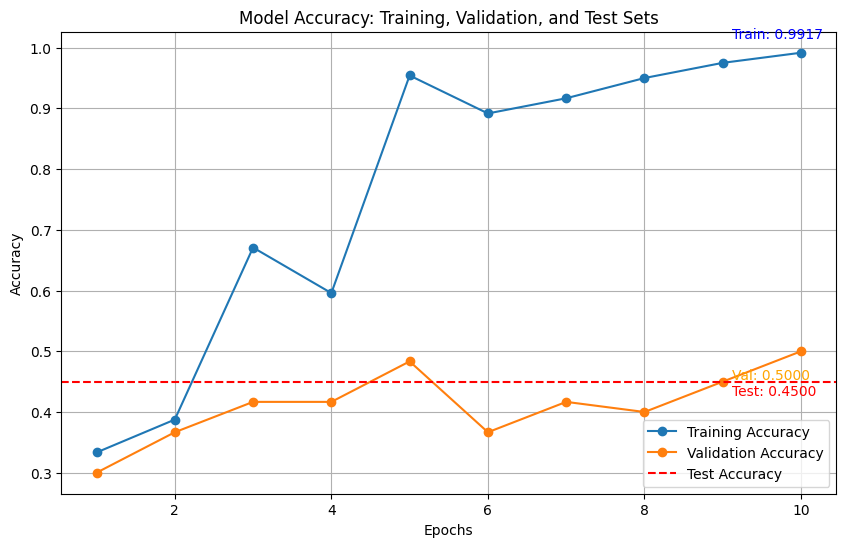

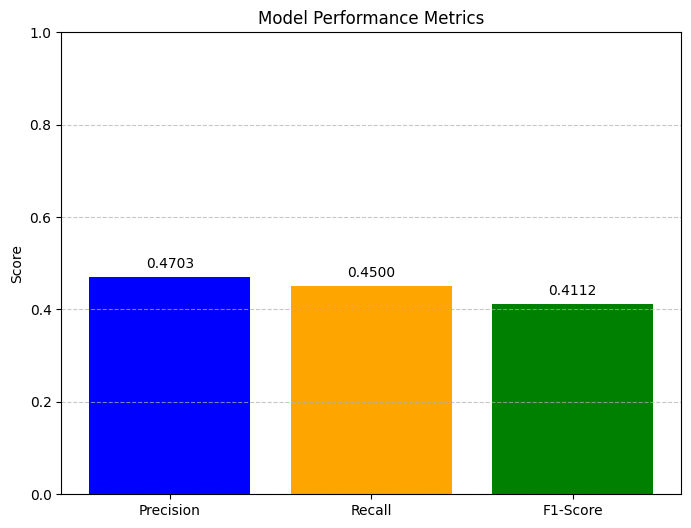

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Extract accuracies and metrics
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)
test_accuracy = final_report['accuracy']
precision = np.mean([v['precision'] for k, v in final_report.items() if k.isdigit()])
recall = np.mean([v['recall'] for k, v in final_report.items() if k.isdigit()])
f1_score = np.mean([v['f1-score'] for k, v in final_report.items() if k.isdigit()])

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Test Accuracy')

# Annotate final values
plt.annotate(f'Train: {train_acc[-1]:.4f}', xy=(len(epochs), train_acc[-1]),
             xytext=(-50, 10), textcoords='offset points', color='blue')
plt.annotate(f'Val: {val_acc[-1]:.4f}', xy=(len(epochs), val_acc[-1]),
             xytext=(-50, -20), textcoords='offset points', color='orange')
plt.annotate(f'Test: {test_accuracy:.4f}', xy=(len(epochs), test_accuracy),
             xytext=(-50, -10), textcoords='offset points', color='red')

# Titles and labels
plt.title('Model Accuracy: Training, Validation, and Test Sets')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot metrics (precision, recall, F1-score)
metrics = [precision, recall, f1_score]
metrics_labels = ['Precision', 'Recall', 'F1-Score']
plt.figure(figsize=(8, 6))
plt.bar(metrics_labels, metrics, color=['blue', 'orange', 'green'])

# Add values on bars
for i, metric in enumerate(metrics):
    plt.text(i, metric + 0.02, f'{metric:.4f}', ha='center', color='black')

# Titles and labels
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Since all metrics range from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


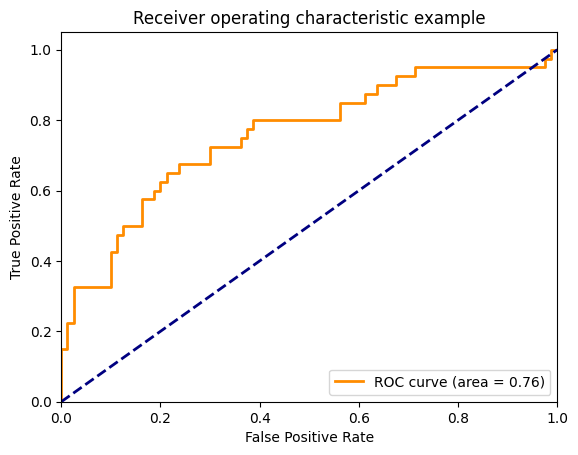

In [21]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_encoded.shape[1] # Assuming you have one-hot encoded labels

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_encoded.ravel(), y_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()